In [ ]:
import torch
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.models
from torchvision import transforms, datasets
import torchvision.transforms as transforms
 
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random
 
import numpy as np
import time

use_cuda = True
!nvidia-smi
 
from google.colab import drive
drive.mount('/content/drive')




Tue Jul 28 05:24:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
use_cuda = True
!7z x "/content/drive/My Drive/APS360 Project 20205 - Team 33/split/carType.7z" -o"/root/"




7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/APS360 Project 20205 - Team 33/split/                                                                       1 file, 2344084826 bytes (2236 MiB)

Extracting archive: /content/drive/My Drive/APS360 Project 20205 - Team 33/split/carType.7z
 11% 4096 Open               23% 8192 Open              WARNING:
/content/drive/My Drive/APS360 Project 20205 - Team 33/split/carType.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/drive/My Drive/APS360 Project 20205 - Team 33/split/carType.7z
Open WAR

In [ ]:
#Models
class VGG16_FC(nn.Module):
    def __init__(self):
        super(VGG16_FC, self).__init__()
        self.name='VGG16_FC'
        self.layer1 = nn.Linear(512 * 7 * 7, 5000)
        self.layer2 = nn.Linear(5000, 1000)
        self.layer3 = nn.Linear(1000, 9)
    def forward(self, img):
        flattened = img.view(-1, 512 * 7 * 7)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output
vgg16 = torchvision.models.vgg16(pretrained=True)


class LicensePlateDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(root))
        self.path_to_data_file = data_file
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)

        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[: , 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 5, 3)
        self.conv3 = nn.Conv2d(5, 20, 3)
        self.conv4 = nn.Conv2d(20, 10, 1)

        self.fc1 = nn.Linear(10*14*14, 1000)
        self.fc2 = nn.Linear(1000, 36)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 10*14*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CNNClassifier()
model.load_state_dict(torch.load(pathSave))
model.cuda()


In [ ]:
transform = transforms.Compose(
        [transforms.Resize([224,224]),transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(root = '/root/split/train', transform= transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)



In [ ]:
!git clone https://github.com/pytorch/vision.git
!cd vision
!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9295 (delta 1), reused 1 (delta 0), pack-reused 9293
Receiving objects: 100% (9295/9295), 11.24 MiB | 4.60 MiB/s, done.
Resolving deltas: 100% (6445/6445), done.


In [ ]:
import utils
test_dir = '/content/drive/My Drive/APS360 Project 20205 - Team 33/Car Images (Taken by us)/SYOGAN_Sedan_1.jpg'
sample = plt.imread(test_dir)


In [ ]:
import pycocotools
import cv2
import numpy as np
import torch
import os
import torchvision
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

True
(4032, 3024, 3)
torch.Size([3, 4032, 3024])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


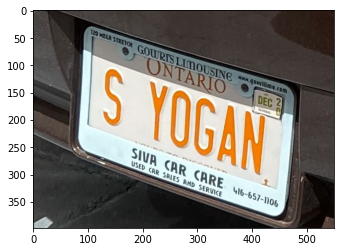

(398, 550, 3)


TypeError: ignored

In [ ]:
def main(image, model = "VGG16", use_cuda = False):
    #car type model
    print(image.shape)
    from PIL import Image
    PIL_image = Image.fromarray(image)
    transformPlate = transforms.Compose(
        [transforms.ToTensor()])
    transformModel = transforms.Compose(
        [transforms.Resize([224,224]),transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    transformChars = transforms.Compose([transforms.Resize([128, 128]),
                                        transforms.Grayscale(1),
                                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    )


    
    imagePlate = transformPlate(PIL_image)
    '''
    pathsave = r"/content/drive/My Drive/APS360 Project 20205 - Team 33/Deep/Models/"
    if model == "VGG16":
      pathsave += r"model_VGG16_FC_bs20_lr0.007_epoch27_val:0.8588571428571429"
      the_model = VGG16_FC()
    if model == "MobileModel":
      pathsave += r"model_MobileModel_bs20_lr0.007_epoch29_val:0.78942857"
    if model == "AlexNet":
      pathsave += r"model_AlexNet_bs50_lr0.007_epoch27_val:0.793"
    the_model.load_state_dict(torch.load(pathsave))
    output = vgg16.features(image)
    if use_cuda and torch.cuda.is_available():
      output.cuda()
      the_model.cuda()
    output = the_model(output).max(1, keepdim=True)[1]
    print(output)
    '''
    #license plate model

    cropped = get_cropped_plate(imagePlate)
    if cropped is None:
      print("No Plate Located")
      plt.imshow(image.numpy().transpose(1, 2, 0))
      plt.show()
    else:
      plt.imshow(cropped)
      plt.show()
      cropped = (cropped*255).astype(np.uint8)
      coords = detectEdges(cropped)
      corners = findCornerPoints(coords)
      transform_plate = transformAndCrop(cropped, corners)
      chars = get_chars(transform_plate)
      plt.show()
      for i in chars:
        image = transformChars(i)
        plt.imshow(transformChars(i))
        plt.show()
        

print(os.path.isfile('/root/split/test/Convertible/Convertible_1.jpg'))
#dataiter = iter(data_loader_test)
#images, labels = dataiter.next()

main(sample)

In [ ]:
def get_cropped_plate(image):
  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load('/content/drive/My Drive/APS360 Project 20205 - Team 33/test_model'))
  root = '/content/drive/My Drive/Test/'
  cropped = None
  # idx = 32 #honda
  # idx = 38
  img = image
  print(img.shape)
  img_np = img.numpy().transpose(1, 2, 0)
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():
    prediction = loaded_model([img])
  for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                      decimals= 4)
    if score > 0.8:
        # draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        # outline ="red", width =3)
        # draw.text((boxes[0], boxes[1]), text = str(score))
        boxes = [int(boxes[i]) for i in range(len(boxes))]
        start_point = (boxes[0], boxes[1]) 
    
        # Ending coordinate, here (220, 220) 
        # represents the bottom right corner of rectangle 
        end_point = (boxes[2], boxes[3]) 
          
        # Blue color in BGR 
        color = (255, 0, 0) 
        color1 = (0, 255, 0)
          
        # Line thickness of 2 px 
        thickness = 10

        cpy = img_np.copy()
        cv2.rectangle(img_np, start_point, end_point, color, thickness)

        h = boxes[3] - boxes[1]
        w = boxes[2] - boxes[0]
        cx = (boxes[2] + boxes[0])//2
        cy = (boxes[3] + boxes[1])//2

        w *= 1.5
        h *= 1.8
        cr_x = int(w//2)
        cr_y = int(h//2)

        # top left
        start_point = (cx-cr_x, cy-cr_y) 

        # bottom right
        end_point = (cx+cr_x, cy+cr_y) 

        cv2.rectangle(img_np, start_point, end_point, color1, thickness)


        #img[y: y+h, x: x+w]
        cropped = cpy[start_point[1]:end_point[1], start_point[0]:end_point[0]]
  return cropped

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

In [ ]:
def convertListToArray(list_in):
    listObj = []
    for item in list_in:
      listObj.append(item[0])
    return np.array([np.array(x) for x in listObj])

In [ ]:
def findContours(img):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find largest contour
    cnt = sorted(cnts, key= lambda x: cv2.contourArea(x))[-1]

    # Find convex hull object for contour
    hull = cv2.convexHull(cnt, False)

    image = cv2.fillPoly(img, pts=[np.array(hull)], color=(255, 255, 255))
    stencil = np.zeros(img.shape).astype(image.dtype)
    resultimg = cv2.bitwise_and(img, stencil)
    #plot_images(img, resultimg)

    return convertListToArray(hull)

In [ ]:
def detectEdges(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(img, 30, 200)

    contourCoords = findContours(edges)
    
    return contourCoords

In [ ]:
def identifyCorners(centroids):
    points = sorted(centroids, key=sum)

    # Top left will be point with lowest sum
    tl = points[0]

    # Bottom right will be point with highest sum
    br = points[3]
    # Identify bottom left and top right points
    if points[1][0] > points[2][0]:
        tr = points[1]
        bl = points[2]
    elif points[1][0] < points[2][0]:
        tr = points[2]
        bl = points[1]
    elif points[1][1] > points[2][1]:
        tr = points[2]
        bl = points[1]  
    else: 
        tr = points[1]
        bl = points[2]  

    br = np.array(br)
    bl = np.array(bl)
    tr = np.array(tr)
    tl = np.array(tl)
    # Find label
    for i, val in enumerate(centroids):
        if np.array_equal(val, tl):
            tl = (tl, i)
        elif np.array_equal(val, tr):
            tr = (tr, i)
        elif np.array_equal(val, bl):
            bl = (bl, i)
        elif np.array_equal(val, br):
            br = (br, i)
    return tl, tr, bl, br

In [ ]:
def findCornerPoints(points):
    xVal = []
    yVal = []

    for point in points:
        xVal.append(point[0])
        yVal.append(point[1])
      
    Data = {
        'x': xVal,
        'y': yVal
    }

    # Convert to pandas dataframe
    df = pd.DataFrame(Data, columns=['x', 'y'])

    kmeans = KMeans(n_clusters=4).fit(df)
    centroids = kmeans.cluster_centers_

    # Show Centroids on plot
    # plt.scatter(df['x'], df['y'])
    # for center in centroids:
    #     plt.scatter(center[0], center[1], s = 100, c = 'r')
    # plt.gca().invert_yaxis()
    # plt.show()

    # Identify location of each centroid
    tl_c, tr_c, bl_c, br_c = identifyCorners(centroids)

    labels = kmeans.labels_
    # Combine points by cluster
    tl_points, tr_points, bl_points, br_points = [], [], [], []

    for i, val in enumerate(labels):
        if val == tl_c[1]:
            tl_points.append(points[i])
        elif val == tr_c[1]:
            tr_points.append(points[i])
        elif val == bl_c[1]:
            bl_points.append(points[i])
        elif val == br_c[1]:
            br_points.append(points[i])

    # plt.scatter(df['x'], df['y'])
    # color = ['r', 'b', 'g', 'y']
    # for point in tl_points:
    #     plt.scatter(point[0], point[1], s = 100, c = 'r')
    # for point in br_points:
    #     plt.scatter(point[0], point[1], s = 100, c = 'b')
    # for point in bl_points:
    #     plt.scatter(point[0], point[1], s = 100, c = 'g')
    # for point in tr_points:
    #     plt.scatter(point[0], point[1], s = 100, c = 'y')
    # plt.gca().invert_yaxis()
    # plt.show()

    # find top left and bottom right points by looking at distance from origin
    tlPoint = sorted(tl_points, key=sum)[0]
    brPoint = sorted(br_points, key=sum)[-1]

    # Set bottom left and top right centroids
    blPoint = bl_c[0].astype(int)
    trPoint = tr_c[0].astype(int)

    finalPoints = [tlPoint, brPoint, blPoint, trPoint]
    # Show final points on plot
    # plt.scatter(df['x'], df['y'])
    # color = ['r', 'b', 'g', 'y']
    # for i in range(4):
    #     point = finalPoints[i]
    #     plt.scatter(point[0], point[1], s = 100, c = color[i])
    # plt.gca().invert_yaxis()
    # plt.show()

    return finalPoints

In [ ]:
def transformAndCrop(img, points):
    print(img.shape)
    height = 300
    width = 400
    srcpts = np.float32(points)
    dstpts = np.float32([[0, 0], [width, height], [0, height], [width, 0]])

    transform = cv2.getPerspectiveTransform(srcpts, dstpts)
    dst = cv2.warpPerspective(img, transform, (width, height))
    return dst

In [ ]:
def plot_images(img1, img2, title1= "", title2 = "", cmap = "gray"):
  fig = plt.figure(figsize=[15, 15])
  ax1 = fig.add_subplot(121)
  ax1.imshow(img1, cmap=cmap)
  ax1.set(xticks=[], yticks = [], title = title1)

  ax2 = fig.add_subplot(122)
  ax2.imshow(img2, cmap=cmap)
  ax2.set(xticks=[], yticks = [], title = title2)

In [ ]:
import cv2
import numpy as np
from imutils import contours
from pathlib import Path
from matplotlib import pyplot as plt
import os

In [ ]:
def get_chars(image):
    chars = []
    image = cv2.resize(image, (1000, 617)) # w = h * 1.62
    mask = np.zeros(image.shape, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    ROI_number = 0
    for i,c in enumerate(cnts):
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        ratio = w/h
        # print(str(i) + " :      " + str(area) + ", " +str(ratio))
        if area < 13000 and area > 1000:
            # print(str(ROI_number) + "--"+ str(i) + " : " + str(area) +  "ratio:" +str(ratio))
            if(ratio > 0.275 and ratio < 0.5):
                # print("--------------------------------")
                # print(i)
                # print("---------------------------------")
                ROI = 255 - thresh[y:y+h, x:x+w]
                cv2.drawContours(mask, [c], -1, (255,255,255), -1)
                chars.append(ROI)
                # cv2.imwrite(dst + "/ROI_{}.png".format(ROI_number), ROI)
                ROI_number += 1
    return chars